<a href="https://colab.research.google.com/github/WilliamShengYangHuang/Image-Classifier/blob/main/Image_Classifier_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classifier for Own Datasets 

**Original Author:** [fchollet](https://twitter.com/fchollet)<br>
**Modified by:** William Huang (ucfnhua@ucl.ac.uk) <br>
**Date created:** 2020/04/27<br>
**Last modified:** 2021/07/11<br>


## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive

## List devices

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4153355647850079104
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3671139544173097613
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

## Load the data



Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [3]:
# Place the dataset in your Google Drive 
drive.mount("/content/drive")

folder_name = 'PetImg/PetImages' #@param{type:"string"}
path = "/content/drive/My Drive/" + folder_name 
print('path = ' + path)

os.chdir(path)
os.listdir(path)

!ls
!ls PetImages

Mounted at /content/drive
path = /content/drive/My Drive/PetImg/PetImages
Cat  Dog  model.png  save_at_1.h5  save_at_2.h5
ls: cannot access 'PetImages': No such file or directory


In [4]:
class_0 = 'Cat' #@param{type:"string"}
# folder name for class 0 images

class_1 = 'Dog' #@param{type:"string"}
# folder name for class 1 images

### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [5]:
"""
num_skipped = 0
for folder_name in (class_0, class_1):
    folder_path = os.path.join(path, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)
"""


'\nnum_skipped = 0\nfor folder_name in (class_0, class_1):\n    folder_path = os.path.join(path, folder_name)\n    for fname in os.listdir(folder_path):\n        fpath = os.path.join(folder_path, fname)\n        try:\n            fobj = open(fpath, "rb")\n            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)\n        finally:\n            fobj.close()\n\n        if not is_jfif:\n            num_skipped += 1\n            # Delete corrupted image\n            os.remove(fpath)\n\nprint("Deleted %d images" % num_skipped)\n'

## Generate a `Dataset`


In [6]:
image_size = (180, 180)
batch_size = 32

training_set_name = 'training' #@param{type:"string"}
validation_set_name = 'validation' #@param{type:"string"}

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset=training_set_name,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset=validation_set_name,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23439 files belonging to 2 classes.
Using 18752 files for training.
Found 23439 files belonging to 2 classes.
Using 4687 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


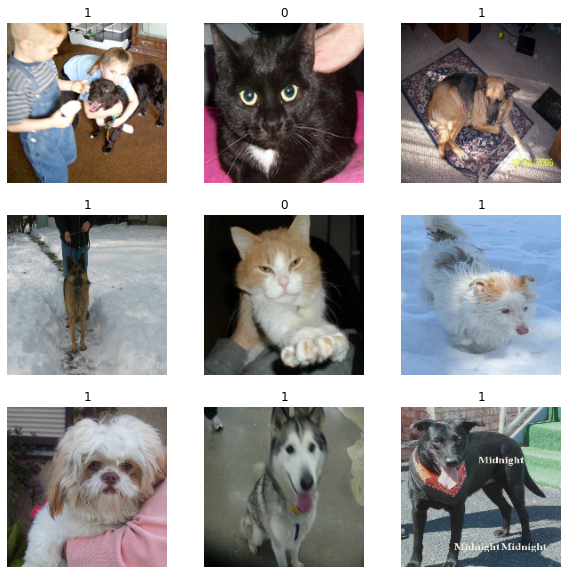

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


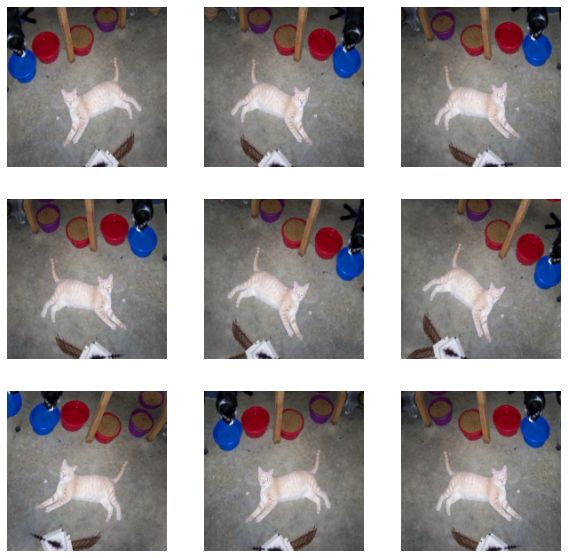

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model (Xception)

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


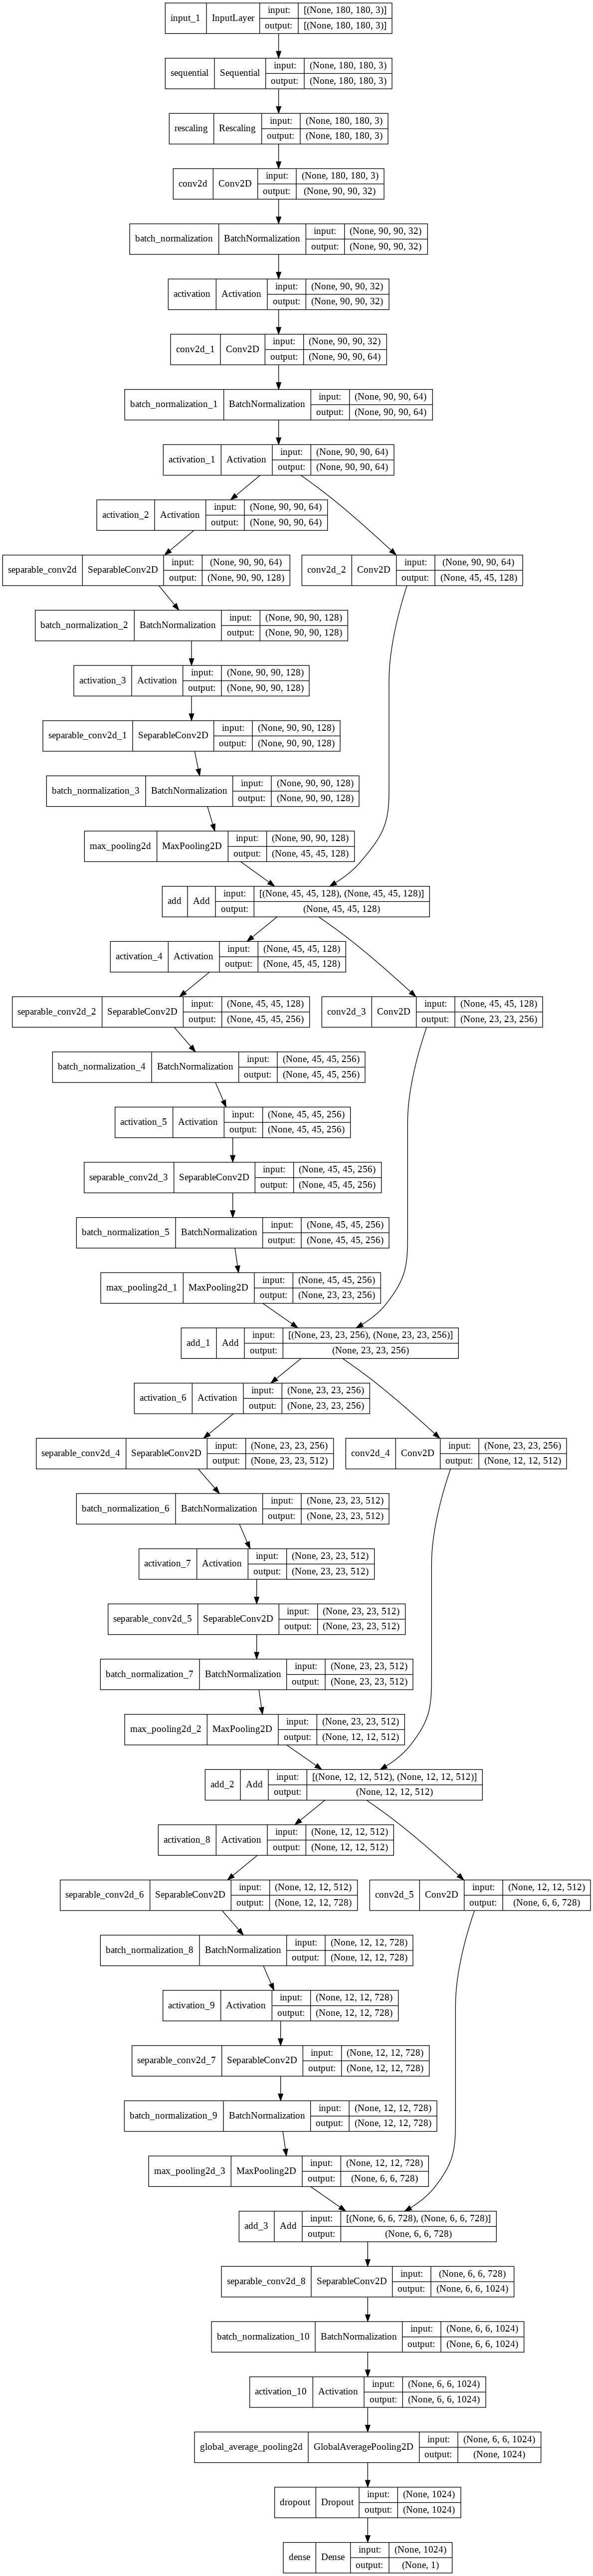

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [ ]:
EPOCHS = 2 #@param {type:"slider", min:1, max:512, step:1} 
######## set epochs number ########--------------------------------------------

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/2
155/586 [======>.......................] - ETA: 9:11 - loss: 0.7133 - accuracy: 0.5857

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
test_image_path = '/content/drive/MyDrive/PetImg/PetImages/Cat/6779.jpg' #@param{type:"string"}
img = keras.preprocessing.image.load_img(test_image_path, 
                                         target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent " + class_0 + " and %.2f percent " + class_1 + "."
    % (100 * (1 - score), 100 * score)
)
